In [3]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

In [10]:
opt = {
    "n_epochs": 1,
    "batch_size": 64,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,
    "n_cpu": 8,
    "latent_dim": 100,
    "img_size": 28,
    "channels": 1,
    "sample_interval": 400
}
img_shape = (opt["channels"], opt["img_size"], opt["img_size"])

cuda = True if torch.cuda.is_available() else False

In [149]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt["latent_dim"], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt["img_size"]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt["batch_size"],
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(opt["n_epochs"]):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt["latent_dim"]))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt["n_epochs"], i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt["sample_interval"] == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/1] [Batch 0/938] [D loss: 0.686325] [G loss: 0.662501]
[Epoch 0/1] [Batch 1/938] [D loss: 0.607357] [G loss: 0.659596]
[Epoch 0/1] [Batch 2/938] [D loss: 0.542491] [G loss: 0.657008]
[Epoch 0/1] [Batch 3/938] [D loss: 0.494028] [G loss: 0.654106]
[Epoch 0/1] [Batch 4/938] [D loss: 0.456819] [G loss: 0.650277]
[Epoch 0/1] [Batch 5/938] [D loss: 0.429062] [G loss: 0.645978]
[Epoch 0/1] [Batch 6/938] [D loss: 0.415131] [G loss: 0.640605]
[Epoch 0/1] [Batch 7/938] [D loss: 0.403155] [G loss: 0.633882]
[Epoch 0/1] [Batch 8/938] [D loss: 0.400726] [G loss: 0.627404]
[Epoch 0/1] [Batch 9/938] [D loss: 0.402274] [G loss: 0.617113]
[Epoch 0/1] [Batch 10/938] [D loss: 0.404496] [G loss: 0.609077]
[Epoch 0/1] [Batch 11/938] [D loss: 0.409592] [G loss: 0.599011]
[Epoch 0/1] [Batch 12/938] [D loss: 0.413032] [G loss: 0.592326]
[Epoch 0/1] [Batch 13/938] [D loss: 0.415918] [G loss: 0.587190]
[Epoch 0/1] [Batch 14/938] [D loss: 0.420298] [G loss: 0.582116]
[Epoch 0/1] [Batch 15/938] [D loss:

In [163]:
gen_imgs.shape

torch.Size([32, 1, 28, 28])

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Dataset & DataLoader

In [128]:
train_dataset = datasets.MNIST(root = "data", train = True, download = True, transform = ToTensor())

In [129]:
class customDataset(Dataset):
    def __int__(self, transform = None, target_transform = None):
        return

    def __len__(self):
        return

    def __get_item__(self, idx):
        return

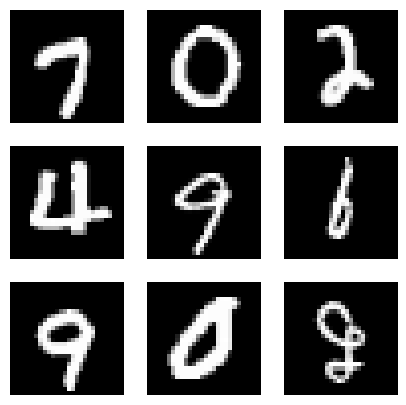

In [130]:
# Visualize the dataset

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [151]:
num_examples = len(train_dataset)

opt = {
    "epochs": 10,
    "batch_size": 64,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,
    "latent_dim": 100,
    "img_size": 28*28,
    "sample_interval": 400
}

cuda = True if torch.cuda.is_available() else False

In [152]:
class Generator(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.lin1 = nn.Linear(dims[0], dims[1])
        self.lin2 = nn.Linear(dims[1], dims[2])
        self.lin3 = nn.Linear(dims[2], dims[3])
        self.lin4 = nn.Linear(dims[3], dims[4])
        self.lin5 = nn.Linear(dims[4], dims[5])
        return

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = F.relu(self.lin5(x))
        return x

In [153]:
class Discriminator(nn.Module):
    def __init__(self, dims = []):
        super().__init__()
        self.lin1 = nn.Linear(dims[0], dims[1])
        self.lin2 = nn.Linear(dims[1], dims[2])
        self.lin3 = nn.Linear(dims[2], dims[3])
        return

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = torch.sigmoid(x)
        return x

In [177]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt["latent_dim"], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        # img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        # img_flat = img.view(img.size(0), -1)
        validity = self.model(img)

        return validity


In [178]:
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = 64)

In [179]:
epochs = opt['epochs']
dimsG = [opt['latent_dim'], 128, 256, 512, 1024, opt['img_size']]
dimsD = [opt['img_size'], 512, 256, 1]

# modelG = Generator(dimsG)
# modelD = Discriminator(dimsD)

modelG = Generator()
modelD = Discriminator()

adversarial_loss = nn.BCELoss()

optimG = optim.Adam(modelG.parameters(), lr = opt["lr"], betas=(opt["b1"], opt["b2"]))
optimD = optim.Adam(modelD.parameters(), lr = opt["lr"], betas=(opt["b1"], opt["b2"]))

D_losses = []
G_losses = []
for i in range(epochs):
    epoch_loss_D = 0
    epoch_loss_G = 0 
    for batch in train_dataloader:

        imgs, _ = batch
        imgs = imgs.flatten(1)

        # Real Img & data labels
        valid = torch.ones((imgs.shape[0], 1), requires_grad = False)

        # Generator
        # sample noise as generator input
        z = torch.randn((imgs.shape[0], opt['latent_dim']))
        genImgs = modelG(z)

        loss_g = -adversarial_loss(modelD(genImgs), valid)
        epoch_loss_G += (loss_g * imgs.shape[0])
        G_losses.append(loss_g)

        optimG.zero_grad()
        loss_g.backward()
        optimG.step()

        # Discriminator
        
        # Fake generated Img & data labels
        fake = torch.zeros((imgs.shape[0], 1), requires_grad = False)
        real_loss_d = adversarial_loss(modelD(imgs), valid)
        fake_loss_d = adversarial_loss(modelD(genImgs.detach()), fake)

        loss_d = real_loss_d + fake_loss_d
        epoch_loss_D += (loss_d * imgs.shape[0])

        optimD.zero_grad()
        loss_d.backward()
        optimD.step()

    epoch_loss_G /= num_examples
    epoch_loss_D /= num_examples
    
    D_losses.append(epoch_loss_D)
    G_losses.append(epoch_loss_G)    

        # if (i + 1) % 10 == 0:
    print(f'At iteration {i + 1}, generator loss is {epoch_loss_G} and discriminator loss is {epoch_loss_D}')
    genImgs = genImgs.view(-1, 1, 28, 28)
    save_image(genImgs.data[:25], "images/predictions_" + str(i + 1) + ".png", nrow=5, normalize=True)

At iteration 1, generator loss is 0.9494006633758545 and discriminator loss is 1.0778493881225586
At iteration 2, generator loss is 1.254130482673645 and discriminator loss is 0.9144999980926514
At iteration 3, generator loss is 1.5099717378616333 and discriminator loss is 0.7979946732521057
At iteration 4, generator loss is 1.7063190937042236 and discriminator loss is 0.7406807541847229
At iteration 5, generator loss is 1.758845567703247 and discriminator loss is 0.7353498339653015
At iteration 6, generator loss is 1.858625888824463 and discriminator loss is 0.6830227375030518
At iteration 7, generator loss is 1.921725869178772 and discriminator loss is 0.6732707619667053
At iteration 8, generator loss is 2.0998289585113525 and discriminator loss is 0.6155593395233154
At iteration 9, generator loss is 2.293013334274292 and discriminator loss is 0.5489183068275452
At iteration 10, generator loss is 2.3857336044311523 and discriminator loss is 0.5313196778297424


In [166]:
genImgs = genImgs.view(-1, 1, 28, 28)
genImgs.shape

torch.Size([32, 1, 28, 28])

In [167]:
save_image(genImgs.data[:25], "images/predictions.png", nrow=5, normalize=True)